In [4]:
# upgrade libraries
# !pip install --user --upgrade scikit-learn tensorflow keras keras-tuner tensorboard numpy pandas matplotlib
# pip freeze > requirements.txt
# !pip install --user --upgrade -r requirements.txt

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib_inline.backend_inline
import plotly.express as px
from ydata_profiling import ProfileReport

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, MaxPooling1D, TimeDistributed, Reshape, Flatten, Dense, Dropout, LSTM, Conv1D
from tensorflow.keras.callbacks import TensorBoard
import tensorboard as tb
from keras_tuner.tuners import BayesianOptimization
from keras_tuner.engine.hyperparameters import HyperParameters

import os
import warnings
import pickle

pd.set_option('display.max_rows', 50)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib notebook
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

TB_LOG_DIR = "src/model_logs/fit"  # Specify the directory for storing TensorBoard logs

tensorboard_callback = TensorBoard(
    log_dir=TB_LOG_DIR,
    histogram_freq=1,  # Frequency (in epochs) for computing histograms
    write_graph=True,  # Whether to write the model graph visualization
    update_freq='epoch'  # Frequency (in 'batch' or 'epoch') for writing TensorBoard summaries
)

BASE_PATH = r'C:\Users\lnick\Documents\UROP\EIT_Touch_Sensor'
DATA_SOURCE = 'output/EIT_Data_Gelatin_4_dof.xlsx'

For Google Colab only: connect to TPU runtime.

In [ ]:
from google.colab import files
import tensorflow as tf

# allocate TPU if possible
print("Tensorflow version " + tf.__version__)
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print('Could not start a TPU. Falling back to GPU.')
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

print('Upload the dataset: EIT_Data_Gelatin.xlsx.')
uploaded = files.upload()

In [6]:
X = pd.read_excel(os.path.join(BASE_PATH, DATA_SOURCE), sheet_name='Voltages')
y = pd.read_excel(os.path.join(BASE_PATH, DATA_SOURCE), sheet_name='Positions')

print(X.shape, y.shape)

(413, 192) (413, 4)


In [7]:
# check spread of (x, y) coordinates
pos_df_fixed = pd.DataFrame(y).drop(columns=['x1', 'y1'])
pos_df_moving = pd.DataFrame(y).drop(columns=['x0', 'y0'])
fig_fixed = px.density_heatmap(pos_df_fixed, x='x0', y='y0', marginal_x='histogram', marginal_y='histogram', nbinsx=10, nbinsy=10)
fig_fixed.show()
fig_moving = px.density_heatmap(pos_df_moving, x='x1', y='y1', marginal_x='histogram', marginal_y='histogram', nbinsx=10, nbinsy=10)
fig_moving.show()

# remove y1 column from y
y.drop(columns=['y1'], inplace=True)

# analyse positions
ProfileReport(y)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

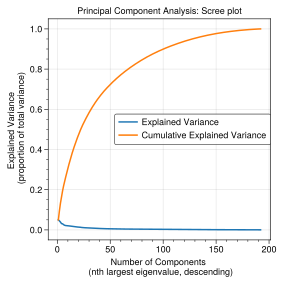

In [8]:
# exploratory PCA
X_std_df = StandardScaler().fit_transform(X)
pca = PCA(n_components=None)
df_pca = pd.DataFrame(pca.fit_transform(X_std_df))
explained_variance = pca.explained_variance_ratio_
plt.plot(range(1, len(explained_variance) + 1), explained_variance, label='Explained Variance')
plt.plot(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), label='Cumulative Explained Variance')
plt.xlabel('Number of Components \n ($n$th largest eigenvalue, descending)')
plt.ylabel('Explained Variance \n (proportion of total variance)')
plt.legend()
plt.title('Principal Component Analysis: Scree plot')
plt.show()

## Classical Regression Algorithms

Models tested:

- Linear regression with PCA
- Polynomial regression with PCA
- Polynomial regression with PCA and regularisation (Lasso and Ridge)
- Random forest
- Support vector machine
- K-nearest neighbours regression
- Multilayer perceptron (simple fully connected neural network)

All models use K-fold cross-validation and optimise hyperparameters to find the best MSE.

In [16]:
# train a series of regression models:
# simple linear, polynomial, lasso, ridge, random forest, svr, knn, mlp
# PCA is used for poly/ridge/lasso

pipeline_linear = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('regression', LinearRegression())
])

pipeline_poly = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=100)),
    ('poly', PolynomialFeatures()),
    ('regression', LinearRegression())
])

pipeline_ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=100)),
    ('poly', PolynomialFeatures(degree=2)),
    ('ridge', Ridge())
])

pipeline_lasso = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=100)),
    ('poly', PolynomialFeatures(degree=2)),
    ('lasso', Lasso())
])

pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor())
])

pipeline_svr = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', MultiOutputRegressor(SVR()))
])

pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor())
])

pipeline_mlp = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor())
])

param_grid_linear = {'pca__n_components': [2, 10, 50, 100, 192]}
param_grid_poly = {'poly__degree': [2, 3]}
param_grid_ridge = {'ridge__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 1e10]}
param_grid_lasso = {'lasso__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 1e10]}
param_grid_rf = {'rf__n_estimators': [10, 100, 1000]}
param_grid_svr = {'svr__estimator__C': [0.001, 0.01, 0.1], 'svr__estimator__epsilon': [0.001, 0.01, 0.1]}
param_grid_knn = {'knn__n_neighbors': [2, 4, 6, 8, 10]}
param_grid_mlp = {'mlp__hidden_layer_sizes': [(100,), (100, 100), (100, 100, 100)],
    'mlp__activation': ['relu', 'tanh', 'logistic'],
    'mlp__alpha': [0.01, 0.1, 1.0]}

def train_model(X: np.ndarray, y: np.ndarray, pipeline: Pipeline, param_grid: dict[str: list],
        model_name: str = '', test_size: float = 0.2, cv: int = 10,
        scoring: str = 'neg_mean_squared_error') -> Pipeline:
    '''
    Train and evaluate a model using grid search cross validation.
    
    #### Arguments
    
    `X` (np.ndarray): full input dataset (features)
    `y` (np.ndarray): full output dataset (target variable)
    `pipeline` (Pipeline): sequence of processing steps and a final estimator.
    `param_grid` (_type_): set of hyperparameters to search over.
    `test_size` (float, default = 0.2): proportion of dataset to use for testing.
    `cv` (int, default = 10): number of folds in cross validation.
    `scoring` (str, default = 'neg_mean_squared_error'): scoring metric for cross validation.
    
    #### Returns
    
    `Pipeline`: the best model found by grid search cross validation.
    '''

    mape = lambda y_test, y_pred: round(mean_absolute_percentage_error(y_test, y_pred), 5)
    mae = lambda y_test, y_pred: round(mean_absolute_error(y_test, y_pred), 5)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=cv, scoring=scoring)
    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)
    print(f'{model_name} - Best hyperparameters: {search.best_params_}')
    print(f'MAPE: {mape(y_test, y_pred)}, MAE: {mae(y_test, y_pred)}')
    return best_model


linear_model = train_model(X, y, pipeline_linear, param_grid_linear, model_name='Linear')
poly_model = train_model(X, y, pipeline_poly, param_grid_poly, model_name='Poly')
ridge_model = train_model(X, y, pipeline_ridge, param_grid_ridge, model_name='Ridge')
lasso_model = train_model(X, y, pipeline_lasso, param_grid_lasso, model_name='Lasso')
rf_model = train_model(X, y, pipeline_rf, param_grid_rf, cv=3, model_name='Random Forest')
svr_model = train_model(X, y, pipeline_svr, param_grid_svr, cv=3, model_name='SVR')
knn_model = train_model(X, y, pipeline_knn, param_grid_knn, cv=3, model_name='KNN')
mlp_model = train_model(X, y, pipeline_mlp, param_grid_mlp, cv=3, model_name='MLP')

Linear - Best hyperparameters: {'pca__n_components': 2}
MAPE: 0.37931, MAE: 0.01509
Poly - Best hyperparameters: {'poly__degree': 3}
MAPE: 0.43043, MAE: 0.01614
Ridge - Best hyperparameters: {'ridge__alpha': 10000000000.0}
MAPE: 0.40692, MAE: 0.0151
Lasso - Best hyperparameters: {'lasso__alpha': 0.05}
MAPE: 0.38722, MAE: 0.01517
Random Forest - Best hyperparameters: {'rf__n_estimators': 1000}
MAPE: 0.41758, MAE: 0.01487
SVR - Best hyperparameters: {'svr__estimator__C': 0.001, 'svr__estimator__epsilon': 0.01}
MAPE: 0.39534, MAE: 0.01512
KNN - Best hyperparameters: {'knn__n_neighbors': 10}
MAPE: 0.38971, MAE: 0.01514
MLP - Best hyperparameters: {'mlp__activation': 'relu', 'mlp__alpha': 1.0, 'mlp__hidden_layer_sizes': (100, 100, 100)}
MAPE: 0.43297, MAE: 0.0168


'\n# fit linear model\nsearch_linear = GridSearchCV(estimator=pipeline_linear, param_grid=param_grid_linear,\n    cv=10, scoring=\'neg_mean_squared_error\')\nsearch_linear.fit(X_train, y_train)\nbest_model_linear = search_linear.best_estimator_\ny_pred_linear = best_model_linear.predict(X_test)\nprint(f\'Linear - best hyperparameter: alpha = {search_linear.best_params_["pca__n_components"]}\')\nprint(f\'Linear - MAPE: {mape(y_test, y_pred_linear)}, MAE: {mae(y_test, y_pred_linear)}\')\n\n# fit poly model\nsearch_poly = GridSearchCV(estimator=pipeline_poly, param_grid=param_grid_poly,\n    cv=10, scoring=\'neg_mean_squared_error\')\nsearch_poly.fit(X_train, y_train)\nbest_model_poly = search_poly.best_estimator_\ny_pred_poly = best_model_poly.predict(X_test)\nprint(f\'Poly - best hyperparameter: degree = {search_poly.best_params_["poly__degree"]}\')\nprint(f\'Poly - MAPE: {mape(y_test, y_pred_poly)}, MAE: {mae(y_test, y_pred_poly)}\')\n\n# fit lasso model - L1 regularisation\nsearch_las

In [3]:
with open('models-3-dof/random_forest.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

NameError: name 'rf_model' is not defined

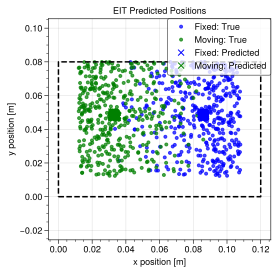

In [8]:
with open(os.path.join(BASE_PATH, 'src/models-3-dof/svr.pkl'), 'rb') as f:
    svr = pickle.load(f)

pos_test = pd.read_excel(os.path.join(BASE_PATH, DATA_SOURCE), sheet_name='Positions')
imp_test = pd.read_excel(os.path.join(BASE_PATH, DATA_SOURCE), sheet_name='Voltages')

pos_pred = svr.predict(imp_test)
pos_pred = np.concatenate((pos_pred, pos_pred[:, -1:]), axis=1)

x_lim = 0.12
y_lim = 0.092

plt.title('EIT Predicted Positions')
plt.xlabel('x position [m]')
plt.ylabel('y position [m]')
plt.plot(pos_test['x0'], pos_test['y0'], 'b.', label=f'Fixed: True', alpha=0.7)
plt.plot(pos_test['x1'], pos_test['y1'], 'g.', label=f'Moving: True', alpha=0.7)
plt.plot(pos_pred[:, 0], pos_pred[:, 2], 'bx', label=f'Fixed: Predicted')
plt.plot(pos_pred[:, 1], pos_pred[:, 3], 'gx', label=f'Moving: Predicted')
plt.plot([0, x_lim, x_lim, 0, 0], [0, 0, y_lim, y_lim, 0], 'k--')
plt.axis('equal')
plt.legend(loc='upper right')
plt.show()